# Learning FLPO

In this code, we will implement the hierarchical ML architecture to predict the parameters in the FLPO setup.

In [ ]:
import torch
from VRP_Net_L import VRPNet_L
from matplotlib import pyplot as plt
from utils import *
import os
import matplotlib.pyplot as plt
from torchinfo import summary
import numpy as np
import time
from torch import optim

# Loading the Data

In [2]:

seed=42;
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print("Running on: " , device)
num_drones = 100 # number of FLPO instances
num_facilities = 500
dim_ = 2
# START and END locations: no grads needed
START_locs = torch.rand(num_drones, 1, dim_, requires_grad=False, device=device)
END_locs   = torch.rand(num_drones, 1, dim_, requires_grad=False, device=device)

# Facility locations: we want grads here
# We create a base tensor with requires_grad=True, then expand it
F_base = torch.rand(1, num_facilities, dim_, requires_grad=True, device=device)
F_locs = F_base.expand(num_drones, -1, -1)  # view, shares grad with F_base
data = torch.cat((START_locs, F_locs, END_locs), dim=1)  # shape: (Nd, Nf+2, D)
print("Data Loaded.")


Running on:  cuda
Data Loaded.


# Loading the VRP NET Module

In [3]:
hidden_dim = 32
num_layers_enc = 1
num_layers_dec = 1
num_heads = 8
torch.cuda.empty_cache()
vrp_net = VRPNet_L(dim_, hidden_dim, device, num_layers_enc, num_layers_dec, num_heads)
vrp_net.load_state_dict(torch.load('Saved models/POMO2025_03_28 19_45_231.101370930671692best_model.pth',weights_only=True))
vrp_net.eval()

# for param in vrp_net.parameters():
#     param.requires_grad = False
print('VRP NET loaded on: ',vrp_net.device)
print(summary(vrp_net))

VRP NET loaded on:  cuda
Layer (type:depth-idx)                                                 Param #
VRPNet_L                                                               --
├─LinearAttnEncoder: 1-1                                               2,560
│    └─MultiheadAttention: 2-1                                         197,376
│    │    └─NonDynamicallyQuantizableLinear: 3-1                       65,792
│    └─Linear: 2-2                                                     768
│    └─Linear: 2-3                                                     8,224
│    └─LayerNorm: 2-4                                                  512
│    └─Dropout: 2-5                                                    --
│    └─ReLU: 2-6                                                       --
├─Decoder: 1-2                                                         --
│    └─TransformerDecoder: 2-7                                         --
│    │    └─ModuleList: 3-2                                      

# Generating d_min

In [44]:

s = time.time()
with torch.no_grad():
    # forward pass: no activations are saved for grad
    _, actions = vrp_net(data, mod='eval_greedy')
print(f"Time: {time.time()-s:.2f}s", )
actions.detach()
d_mins = route_cost(data,actions)

print(d_mins)
torch.cuda.empty_cache()


Time: 4.58s
tensor([0.0415, 2.6687, 2.4110, 2.3447, 2.5296, 2.5189, 0.8092, 0.1869, 0.7044,
        2.3178, 1.8981, 3.4951, 2.5454, 0.0719, 0.3187, 3.3989, 2.5723, 0.3299,
        1.3470, 0.9555, 1.6029, 1.0371, 0.3269, 0.4108, 2.1969, 0.6331, 0.9852,
        0.8339, 2.6408, 2.0714, 3.2424, 0.3746, 2.4443, 0.3428, 1.5078, 0.2086,
        2.1435, 3.6214, 2.3391, 2.5481, 0.5070, 1.4093, 3.5332, 1.7715, 2.7245,
        0.7523, 0.7124, 1.1901, 2.1854, 0.6041, 2.0345, 0.8130, 3.6162, 0.3967,
        0.6948, 3.3399, 0.6180, 0.0308, 2.3670, 2.4885, 0.4342, 0.1336, 0.5692,
        1.7286, 0.1112, 0.1873, 0.8573, 1.9137, 2.2196, 1.8206, 0.2638, 0.6185,
        2.4196, 0.4128, 0.7338, 1.6731, 1.2428, 0.4067, 1.0655, 1.0202, 1.9492,
        2.4874, 0.2882, 1.5001, 0.2049, 1.1155, 0.0829, 1.6937, 0.3063, 3.4723,
        1.3522, 0.4058, 2.9228, 1.6015, 0.3911, 0.6516, 2.5834, 1.5128, 2.2863,
        2.8225], device='cuda:0', grad_fn=<SumBackward1>)


In [13]:
d_mins.requires_grad

True

In [14]:
d_mins.shape

torch.Size([100])

In [15]:
# all_samples = torch.zeros(num_data, num_nodes, num_samples).to(device)
# for i in range(num_samples):
#     _, actions = vrpnet(data, mod='train')
#     all_samples[:,:,i:i+1] = actions
# opt_sample_indices = []


In [16]:
# d_mins = np.zeros(num_data)
# for data_idx in range(num_data):
#     costs_for_data = [route_cost(data[data_idx:data_idx+1], all_samples[data_idx:data_idx+1, :, sample_idx]) for sample_idx in range(num_samples)]
#     costs_tensor = torch.tensor(costs_for_data)
#     d_min, opt_sample_index = torch.min(costs_tensor, dim=0)  
#     opt_sample_indices.append(opt_sample_index.item())
#     d_mins[data_idx] = d_min
# opt_sample_indices = torch.tensor(opt_sample_indices)
# actions = all_samples[torch.arange(num_data),:,opt_sample_indices]
# print("d_mins for all data are: ",d_mins)

# Loading Free Energy Network

Dhananjay's code for loading his DNN is here. The output of this block should be Y.

In [22]:
import LSE_net
lse_data = torch.load('logSumExp_models/dnn_2543_1624.pth')
n_inputs = lse_data['n_inputs']
n_outputs = lse_data['n_outputs']
layers = lse_data['layers']
weights = lse_data['model_state_dict']
lse_net = LSE_net.dnn(n_inputs, n_outputs, layers)
lse_net.to(device)
lse_net.load_state_dict(weights)
lse_net.eval()
for p in lse_net.parameters():
    p.requires_grad = False
print(f'n_inputs:{n_inputs}\tn_outputs:{n_outputs}\tlayers:{layers}\nlse_net:\n{lse_net}')
print(summary(lse_net))

n_inputs:3	n_outputs:1	layers:[20, 10]
lse_net:
dnn(
  (layers): ModuleList(
    (0): Linear(in_features=3, out_features=20, bias=True)
    (1): ReLU()
    (2): Linear(in_features=20, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=1, bias=True)
  )
)
Layer (type:depth-idx)                   Param #
dnn                                      --
├─ModuleList: 1-1                        --
│    └─Linear: 2-1                       (80)
│    └─ReLU: 2-2                         --
│    └─Linear: 2-3                       (210)
│    └─ReLU: 2-4                         --
│    └─Linear: 2-5                       (11)
Total params: 301
Trainable params: 0
Non-trainable params: 301


C:\Users\salar\AppData\Local\Temp\ipykernel_18476\843068783.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  lse_data = torch.load('logSumExp_models/dnn_2543_1624.pth')


# Calculating Free Energy

Feeding the d_min from Salar Block to get the Free energy

In [45]:
b_arr = lse_data['b_arr']
len_Darray = torch.tensor(lse_data['len_Darray'], dtype=torch.float32)
io_scale = lse_data['io_scale']
b_min = torch.tensor(b_arr[0], dtype=torch.float32)
b_max = torch.tensor(b_arr[-1], dtype=torch.float32)
# d_min_random = np.random.choice(d_mins, 1)[0]
# d_min_random = d_mins[0]
st = 0
# In = torch.tensor([[-io_scale/b_min*np.log(len_Darray), io_scale*d_min_random, b] for b in b_arr], dtype=torch.float32)
In = torch.cat((torch.ones((num_drones,1)).to(device)*(-io_scale/b_min*torch.log(len_Darray)).to(device), d_mins.view(-1,1), torch.ones((num_drones,1)).to(device)*b_max.to(device)), axis=1) #, torch.ones((num_drones,1)).to(device)*b_min.to(device)),axis=1)

# In = torch.cat((torch.ones((num_drones,1)).to(device)*(-io_scale/b_min*torch.log(len_Darray)).to(device), d_mins.view(-1,1), torch.ones((num_drones,1)).to(device)*b_min.to(device)),axis=1)

print(In)
Out = lse_net(In)
FreeEnergy = torch.mean(Out)
print(FreeEnergy)

FreeEnergy.backward()
# print(In.grad)

tensor([[-5.2983e+00,  4.1452e-02,  1.0111e+02],
        [-5.2983e+00,  2.6687e+00,  1.0111e+02],
        [-5.2983e+00,  2.4110e+00,  1.0111e+02],
        [-5.2983e+00,  2.3447e+00,  1.0111e+02],
        [-5.2983e+00,  2.5296e+00,  1.0111e+02],
        [-5.2983e+00,  2.5189e+00,  1.0111e+02],
        [-5.2983e+00,  8.0916e-01,  1.0111e+02],
        [-5.2983e+00,  1.8694e-01,  1.0111e+02],
        [-5.2983e+00,  7.0439e-01,  1.0111e+02],
        [-5.2983e+00,  2.3178e+00,  1.0111e+02],
        [-5.2983e+00,  1.8981e+00,  1.0111e+02],
        [-5.2983e+00,  3.4951e+00,  1.0111e+02],
        [-5.2983e+00,  2.5454e+00,  1.0111e+02],
        [-5.2983e+00,  7.1922e-02,  1.0111e+02],
        [-5.2983e+00,  3.1868e-01,  1.0111e+02],
        [-5.2983e+00,  3.3989e+00,  1.0111e+02],
        [-5.2983e+00,  2.5723e+00,  1.0111e+02],
        [-5.2983e+00,  3.2992e-01,  1.0111e+02],
        [-5.2983e+00,  1.3470e+00,  1.0111e+02],
        [-5.2983e+00,  9.5545e-01,  1.0111e+02],
        [-5.2983e+00

In [46]:

optimizer = optim.Adam([F_base], lr=1e-3)
optimizer.step()

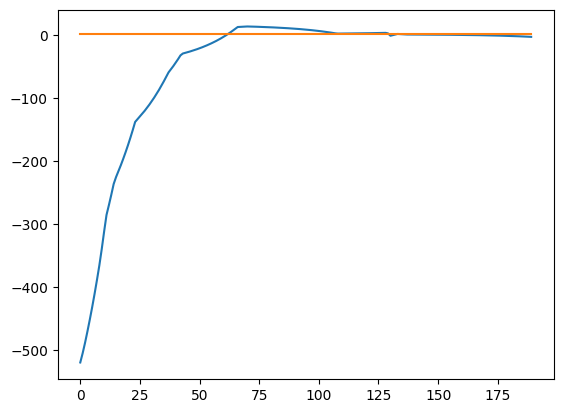

In [59]:
Out_numpy = Out.view(-1).detach().numpy()/io_scale
plt.plot(Out_numpy)
plt.plot(d_min_random*np.ones(Out_numpy.shape))
plt.show()

# Calculating the gradients

The output of this block shoud be dF/dy

First calculate $\frac{\partial F}{\partial d_{min}}$ (code in progress)

In [63]:
# fix beta
b = np.random.choice(b_arr)
d_mins_torch = torch.tensor(d_mins, dtype=torch.float32, requires_grad=True).view(-1,1)
const_bmin = -io_scale/b_arr[0] * np.log(len_Darray) * torch.ones(len(d_mins), dtype=torch.float32).view(-1,1)
const_b = b * torch.ones(len(d_mins), dtype=torch.float32).view(-1,1)
In = torch.concatenate((const_bmin, d_mins_torch, const_b), axis=1)
Out = lse_net(In)
# print(Out)
Out[0].retain_grad()
Out[0].backward()
d_mins_torch.grad

/var/folders/sh/ndxykdmj1q9cwr2kpvkvcbs80000gn/T/ipykernel_89473/1274708057.py:11: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  d_mins_torch.grad


# Running CLF to determin Y

The GD code here

# Closing the Beta Loop for Annealing